In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler,LabelEncoder,RobustScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV

In [3]:
dataDF = pd.read_csv('./Hamburger.csv', encoding= 'latin1')

In [4]:
dataDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   restaurant  1066 non-null   object 
 1   item        1066 non-null   object 
 2   calories    1066 non-null   float64
 3   sodium      1066 non-null   float64
 4   sugar       1066 non-null   float64
 5   total_fat   1066 non-null   float64
 6   protein     1066 non-null   float64
dtypes: float64(5), object(2)
memory usage: 58.4+ KB


In [5]:
# 인코딩
dataDF['restaurant'].nunique()  # 총 13개의 브랜드

11

In [6]:
dataDF['restaurant'].unique() # Mcdonalas와 macdonald / Burger King과 burgerking => 이름 통일

array(['McDonalds', 'Chick Fil-A', 'Sonic', 'Arbys', 'Burger King',
       'Dairy Queen', 'Subway', 'Taco Bell', 'lotteria',
       'no_brand_burger', 'prank_burger'], dtype=object)

In [7]:
dataDF['restaurant'].replace('macdonald','McDonalds',inplace=True)
dataDF['restaurant'].replace('Mcdonald','McDonalds',inplace=True)
dataDF['restaurant'].replace('Mcdonalds','McDonalds',inplace=True)
dataDF['restaurant'].replace('burgerking','Burger King',inplace = True)

In [8]:
dataDF['restaurant'].unique()

array(['McDonalds', 'Chick Fil-A', 'Sonic', 'Arbys', 'Burger King',
       'Dairy Queen', 'Subway', 'Taco Bell', 'lotteria',
       'no_brand_burger', 'prank_burger'], dtype=object)

In [9]:
# 중복값 제거 - 2개 
dataDF.duplicated().sum()
dataDF.drop_duplicates(inplace=True)

In [10]:
# 결측치 제거 - protein - 94개
dataDF.isna().sum()
dataDF.dropna(subset = 'protein',inplace = True)
# 결측치 제거 확인
dataDF.isna().sum()

restaurant    0
item          0
calories      0
sodium        0
sugar         0
total_fat     0
protein       0
dtype: int64

In [11]:
# 순서가 없는 범주형 데이터 -> 원핫인코딩 실시
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(dataDF[['restaurant']])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['restaurant']))
encodingDF = pd.concat([dataDF,encoded_df],axis=1)

In [12]:
encodingDF.corr(numeric_only=True)['calories'].abs().sort_values(ascending=False) # 맥도날드인가 아닌가는 상관계수 넣어볼 만 하다.

calories                      1.000000
sodium                        0.811997
total_fat                     0.722992
sugar                         0.305176
protein                       0.172225
restaurant_no_brand_burger    0.116372
restaurant_Sonic              0.110138
restaurant_McDonalds          0.094981
restaurant_lotteria           0.047757
restaurant_Arbys              0.044778
restaurant_Burger King        0.041003
restaurant_Chick Fil-A        0.038979
restaurant_Subway             0.033058
restaurant_Dairy Queen        0.031482
restaurant_Taco Bell          0.024268
restaurant_prank_burger       0.023250
Name: calories, dtype: float64

In [13]:
dataDF.corr(numeric_only=True)['calories'].sort_values(ascending=False) 

calories     1.000000
sodium       0.811997
total_fat    0.722992
sugar        0.305176
protein      0.172225
Name: calories, dtype: float64

In [14]:
# 타겟 : calories
# 피쳐 : sodium, sugar, total_fat, portein
targetSR = dataDF['calories']
featureDF = dataDF[dataDF.columns[3:]]
targetSR.shape , featureDF.shape

((1066,), (1066, 4))

In [15]:
# 피쳐들끼리 상호관계 있는지 확인
featureDF.corr() # total_fat과 sodium 상관관계 높음

,sodium,sugar,total_fat,protein
sodium,1.000000,-0.096583,0.706748,0.005111
sugar,-0.096583,1.000000,-0.055417,0.065812
total_fat,0.706748,-0.055417,1.000000,0.093125
protein,0.005111,0.065812,0.093125,1.000000


In [16]:
#  total_fat과 sodium poly 진행 
selected_features = ['total_fat', 'sodium']

poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(featureDF[selected_features])
poly_featureDF = pd.DataFrame(poly_features, columns=poly.get_feature_names_out())

# 다항 특성을 포함한 데이터프레임과 원래의 데이터프레임을 합치기
dataDF = pd.concat([dataDF, poly_featureDF], axis=1)


In [22]:
dataDF.isna().sum()

restaurant            0
item                  0
calories              0
sodium                0
sugar                 0
total_fat             0
protein               0
total_fat             0
sodium                0
total_fat^2           0
total_fat sodium      0
sodium^2              0
total_fat^3           0
total_fat^2 sodium    0
total_fat sodium^2    0
sodium^3              0
dtype: int64

In [ ]:
poly_featureDF

,0,1,2,3,4,5,6,7,8
0,7.00,1110.00,49.0000,7770.0000,1.232100e+06,343.000000,5.439000e+04,8.624700e+06,1.367631e+09
1,45.00,1580.00,2025.0000,71100.0000,2.496400e+06,91125.000000,3.199500e+06,1.123380e+08,3.944312e+09
2,67.00,1920.00,4489.0000,128640.0000,3.686400e+06,300763.000000,8.618880e+06,2.469888e+08,7.077888e+09
3,31.00,1940.00,961.0000,60140.0000,3.763600e+06,29791.000000,1.864340e+06,1.166716e+08,7.301384e+09
4,45.00,1980.00,2025.0000,89100.0000,3.920400e+06,91125.000000,4.009500e+06,1.764180e+08,7.762392e+09
...,...,...,...,...,...,...,...,...,...
1061,19.51,4.55,380.6401,88.7705,2.070250e+01,7426.288351,1.731912e+03,4.039058e+02,9.419637e+01
1062,18.10,13.58,327.6100,245.7980,1.844164e+02,5929.741000,4.448944e+03,3.337937e+03,2.504375e+03
1063,22.28,6.42,496.3984,143.0376,4.121640e+01,11059.756352,3.186878e+03,9.183014e+02,2.646093e+02
1064,10.60,13.84,112.3600,146.7040,1.915456e+02,1191.016000,1.555062e+03,2.030383e+03,2.650991e+03


In [23]:

dataDF.dropna(inplace=True)
targetSR = dataDF['calories']
featureDF = dataDF[dataDF.columns[3:]]
featureDF.shape, targetSR.shape

((1066, 17), (1066,))

In [ ]:
poly_featureDF

,0,1,2,3,4,5,6,7,8
0,7.00,1110.00,49.0000,7770.0000,1.232100e+06,343.000000,5.439000e+04,8.624700e+06,1.367631e+09
1,45.00,1580.00,2025.0000,71100.0000,2.496400e+06,91125.000000,3.199500e+06,1.123380e+08,3.944312e+09
2,67.00,1920.00,4489.0000,128640.0000,3.686400e+06,300763.000000,8.618880e+06,2.469888e+08,7.077888e+09
3,31.00,1940.00,961.0000,60140.0000,3.763600e+06,29791.000000,1.864340e+06,1.166716e+08,7.301384e+09
4,45.00,1980.00,2025.0000,89100.0000,3.920400e+06,91125.000000,4.009500e+06,1.764180e+08,7.762392e+09
...,...,...,...,...,...,...,...,...,...
1061,19.51,4.55,380.6401,88.7705,2.070250e+01,7426.288351,1.731912e+03,4.039058e+02,9.419637e+01
1062,18.10,13.58,327.6100,245.7980,1.844164e+02,5929.741000,4.448944e+03,3.337937e+03,2.504375e+03
1063,22.28,6.42,496.3984,143.0376,4.121640e+01,11059.756352,3.186878e+03,9.183014e+02,2.646093e+02
1064,10.60,13.84,112.3600,146.7040,1.915456e+02,1191.016000,1.555062e+03,2.030383e+03,2.650991e+03


In [ ]:
r_max = heejin.find_random_state(featureDF,targetSR)

radom_state = 29
score : 0.9160878170953889


In [ ]:
# 학습용 데이터셋, 검증용 데이터셋 분리
xtrain,xtest,ytrain,ytest = train_test_split(featureDF,targetSR,test_size=0.2, random_state=r_max)

In [ ]:
# 스케일링 진행
heejin.find_scaler(xtrain,ytrain,xtest,ytest, RandomForestRegressor()) # mae와 rmse가 제일 낮은 StandardScaler() 선택

model : RandomForestRegressor()
scaler : StandardScaler()
Train score : 0.980039394471422
Test score : 0.9488396503388826

[모델 설명도]
R2 : 0.9488396503388826
[에러]
MAE : 54.2295523076923
MSE : 6715.183156399071
RMSE : 81.94622112336279

--------------------------------------
model : RandomForestRegressor()
scaler : MinMaxScaler()
Train score : 0.9797551235093989
Test score : 0.9482872351890835

[모델 설명도]
R2 : 0.9482872351890835
[에러]
MAE : 53.62939367521367
MSE : 6787.691826371858
RMSE : 82.38744944693856

--------------------------------------
model : RandomForestRegressor()
scaler : RobustScaler()
Train score : 0.9805065818190594
Test score : 0.9481743948279964

[모델 설명도]
R2 : 0.9481743948279964
[에러]
MAE : 55.07977213675213
MSE : 6802.502977920929
RMSE : 82.47728764890931

--------------------------------------


In [ ]:
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [ ]:
for i in range(1,100):
    model = RandomForestRegressor(random_state=i)
    model.fit(xtrain, ytrain)
    if model.score(xtrain,ytrain)> 0.98:
        print(i,model.score(xtrain,ytrain), model.score(xtest,ytest))

6 0.9805605620789309 0.9449858656402821


KeyboardInterrupt: 

In [ ]:
model = RandomForestRegressor(random_state=31)
model.fit(xtrain, ytrain)

RandomForestRegressor(random_state=31)

In [ ]:
model.score(xtrain,ytrain),model.score(xtest, ytest) # 조금 과적합

(0.9823189394248952, 0.9475840896017644)

Text(0.5, 1.0, '[feature importance]')

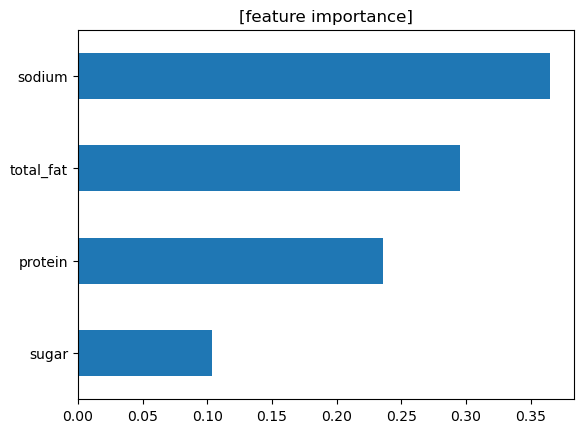

In [ ]:
# feature importance 확인
import_feature = pd.Series(model.feature_importances_, index=featureDF.columns)
import_feature.sort_values(ascending=True, inplace=True)
import_feature.plot(kind='barh')
plt.title('[feature importance]')

max_depth : 과적합을 방지하기 위하여 의사결정나무의 depth 최대 값을 제한
min_samples_split : split을 끝낼 node의 sample 최소 갯수 선정, 클수록 과적합이 방지되지만, 너무 크면 split이 제대로 되지 않을 수 있음

In [ ]:
# 랜덤 포레스트 모델 파라미터 조절

params = { 'n_estimators' : [10,50,100,200,400],
           'max_depth' : [5,10,15,20],
           'min_samples_split' : [5,10,15,20],
            }

cv = GridSearchCV(model, param_grid=params,return_train_score=True)
cv.fit(xtrain,ytrain)

GridSearchCV(estimator=RandomForestRegressor(random_state=31),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [5, 10, 15, 20],
                         'n_estimators': [10, 50, 100, 200, 400]},
             return_train_score=True)

In [ ]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.018190,0.001125,0.001424,0.000499,5,5,10,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",0.812389,0.857566,...,0.836795,0.037319,51,0.908964,0.923837,0.924962,0.924173,0.934568,0.923301,0.008201
1,0.127313,0.055978,0.004874,0.001498,5,5,50,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",0.836078,0.868956,...,0.839216,0.043481,37,0.914278,0.928131,0.926621,0.925017,0.935887,0.925987,0.006943
2,0.246038,0.014073,0.009586,0.001218,5,5,100,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",0.821792,0.869040,...,0.836942,0.041445,50,0.913025,0.927530,0.927991,0.924200,0.935851,0.925719,0.007410
3,0.501319,0.051990,0.017482,0.001766,5,5,200,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",0.828085,0.866512,...,0.838175,0.041310,45,0.913108,0.926059,0.927921,0.924187,0.935997,0.925454,0.007371
4,0.983892,0.087797,0.033831,0.002231,5,5,400,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",0.824722,0.865707,...,0.837750,0.039766,46,0.912654,0.926786,0.927504,0.924080,0.934394,0.925084,0.007084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.027507,0.002325,0.001795,0.000399,20,20,10,"{'max_depth': 20, 'min_samples_split': 20, 'n_...",0.764947,0.880862,...,0.825477,0.054830,73,0.887722,0.909500,0.908819,0.919569,0.898395,0.904801,0.010854
76,0.131149,0.004841,0.004187,0.000399,20,20,50,"{'max_depth': 20, 'min_samples_split': 20, 'n_...",0.794231,0.889825,...,0.834951,0.051896,54,0.898956,0.912001,0.913735,0.921032,0.914798,0.912104,0.007246
77,0.228184,0.006462,0.006654,0.000416,20,20,100,"{'max_depth': 20, 'min_samples_split': 20, 'n_...",0.781817,0.887904,...,0.830862,0.050240,63,0.896313,0.911805,0.920536,0.917058,0.918072,0.912757,0.008701
78,0.491719,0.015158,0.014063,0.000989,20,20,200,"{'max_depth': 20, 'min_samples_split': 20, 'n_...",0.787482,0.886196,...,0.831467,0.048336,61,0.896870,0.910770,0.921923,0.915545,0.917059,0.912433,0.008557


In [ ]:
best_model = cv.best_estimator_
cv.best_estimator_

RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=50,
                      random_state=31)

In [ ]:
best_model.score(xtrain,ytrain),best_model.score(xtest,ytest) # 와 씨 과적합 해결;;

(0.9696443644567738, 0.954502024193393)

In [ ]:
import joblib
import os

In [ ]:
# 모델 저장
model_dir = '../model/'
model_filename = model_dir + 'hamburger_rf.pkl'

# 저장 폴더 존재 여부 확인 후 저장
if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
joblib.dump(best_model,model_filename)

['../model/hamburger_rf.pkl']